In this exercise, the task is to **train a regression model** to predict housing prices. To do this, you will use the *Boston Housing Dataset*, which contains data from the U.S. Census Service and contains data about housing in the area of Boston, Massachusetts. 

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, Input, Model

**Load the dataset** either via [sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-house-prices-dataset) or directly from its [original source](http://lib.stat.cmu.edu/datasets/boston)
into two *pandas* DataFrames X and Y (the features and target).

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
features_column = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
]
target_col = ["MEDV"]

data = pd.DataFrame(data, columns=features_column)
target = pd.DataFrame(target, columns=target_col)

Provide a **description** of the dataset in *pandas*. This will help you to get a first overview.

In [4]:
# 'describe()' the dataset
data.describe(include="all")

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


**Clean up the data** by checking for missing values and removing them.

*Hint: DataFrames have a built-in method for doing that.*

In [5]:
# remove missing entries (if there are any)
data.dropna(axis=0, how="any", inplace=True)

To better understand the dataset, **visualize** correlations between feature values and target values. This should highlight which features are most important for our models.

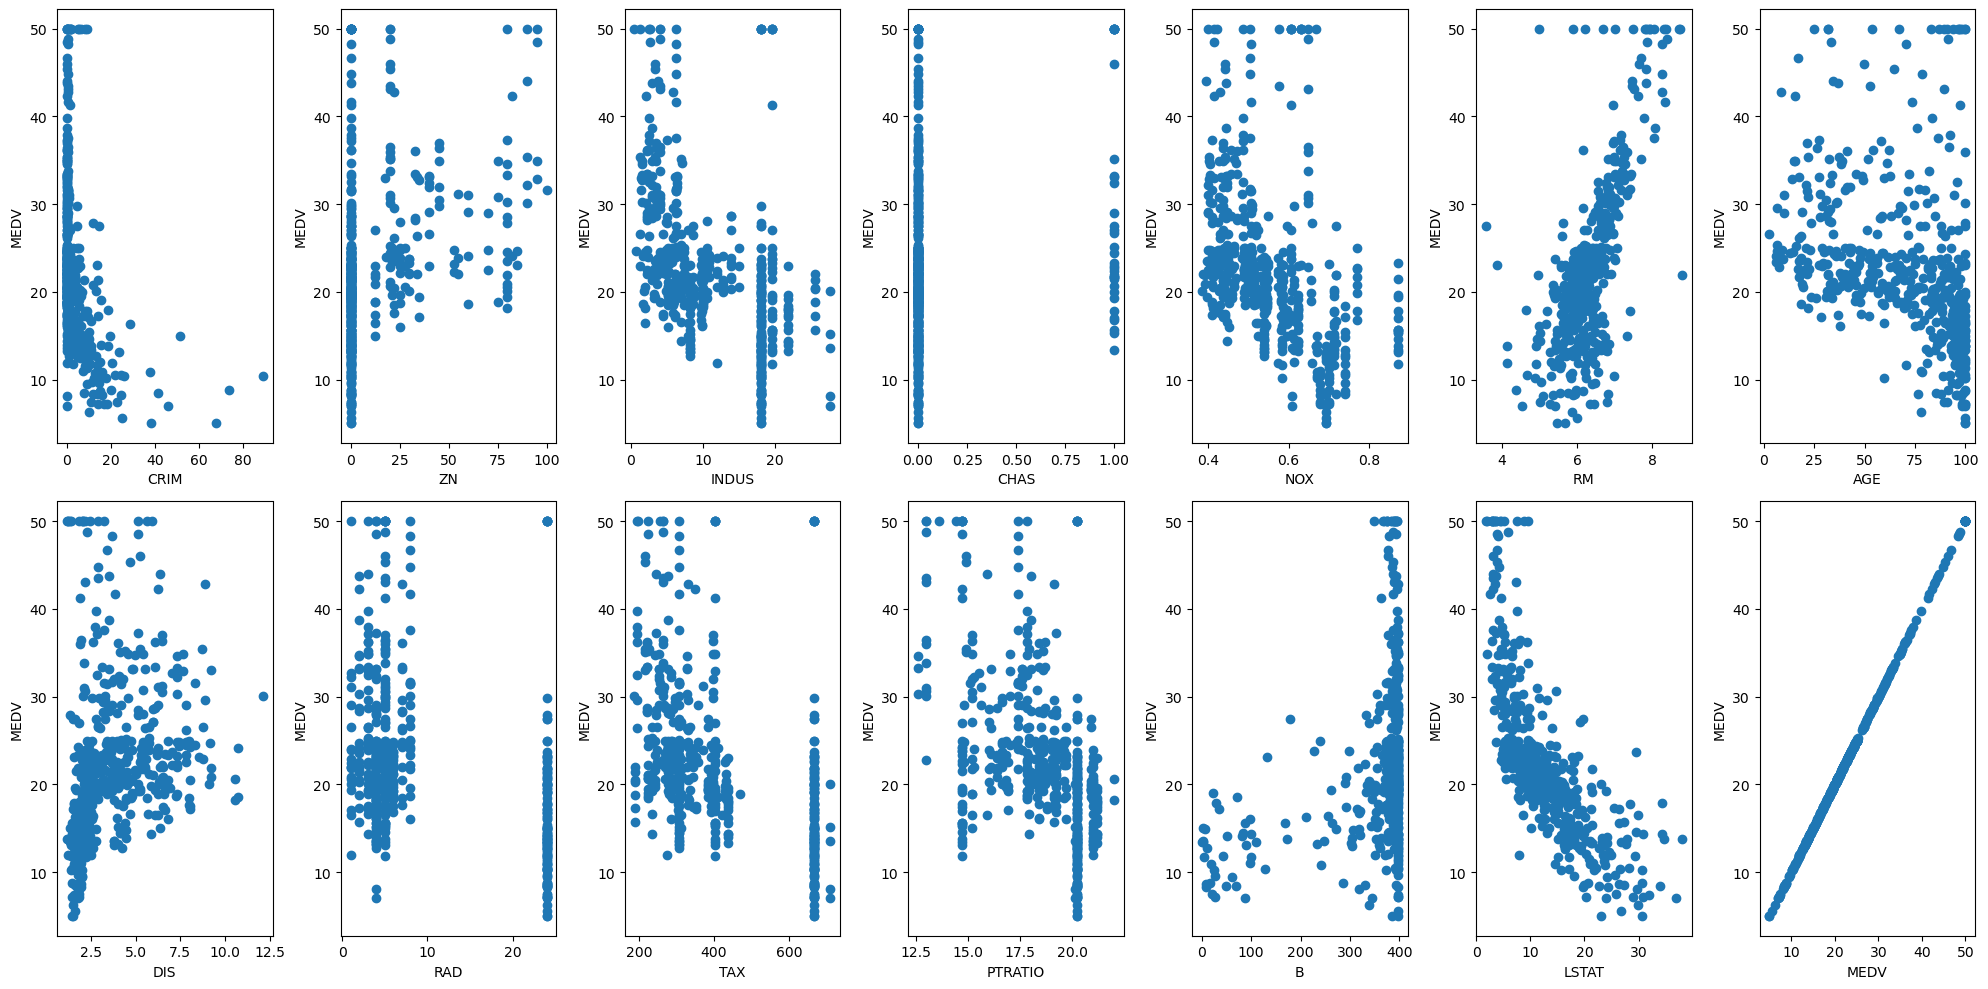

In [6]:
# visualize the distribution of features
data_all = data.join(target)
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
col_ind = 0
for ax in axs.flatten():
    col_name = data_all.iloc[:, col_ind].name
    ax.scatter(x=data_all[col_name], y=data_all["MEDV"])
    ax.set_ylabel("MEDV")
    ax.set_xlabel(col_name)
    col_ind += 1
plt.tight_layout()

As you should be able to see from the scatter plots, features 'CHAS' and 'RAD' appear to be categorical values, as they form straight lines (vertical lines, if target value is represented by the y-axis). This coincides with the dataset attribute description.

**Visualize** the distribution of each feature using a plot of your choice. Additionally, **plot the cross-correlations** of all features. This will highlight redundancies in our dataset.

*Hint: DataFrames have built-in methods for simple visualizations. You may use them.*

correlate_values of CRIM and ZN is [468.70266]
correlate_values of ZN and INDUS is [20903.09]
correlate_values of INDUS and CHAS is [445.17]
correlate_values of CHAS and NOX is [20.7699]
correlate_values of NOX and RM is [1751.5194139]
correlate_values of RM and AGE is [215670.1759]
correlate_values of AGE and DIS is [109297.47009]
correlate_values of DIS and RAD is [13758.179]
correlate_values of RAD and TAX is [2647159.]
correlate_values of TAX and PTRATIO is [3897240.]
correlate_values of PTRATIO and B is [3313095.383]
correlate_values of B and LSTAT is [2163060.5584]


<AxesSubplot: >

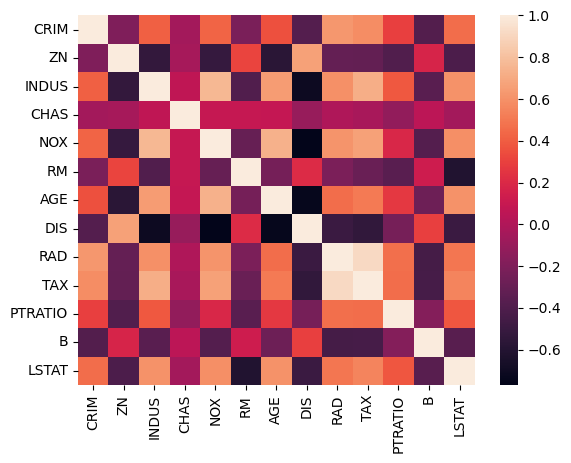

In [7]:
# calculate and print the cross-correlation matrix for X
def corr_features(X, Y):
    return np.correlate(X, Y)

col_names = list(data.columns)
for col_ind, col_name in enumerate(col_names):
    if col_ind == len(col_names)-1:
        break
    correlate_values = corr_features(data[col_names[col_ind]], data[col_names[col_ind + 1]])
    print(f"correlate_values of {col_name} and {col_names[col_ind + 1]} is {correlate_values}")
                                     
# visualize the cross-correlations between all features
sns.heatmap(data.corr())

Now, **preprocess the data and targets** by normalizing continuous features using mean normalization and one-hot-encoding categorical features (CHAS is already one-hot-encoded).

In [8]:
# normalize continuous features
cont_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

normalizers = {c: StandardScaler() for c in cont_features}
for c, Scaler in normalizers.items():
    data[c] = Scaler.fit_transform(data[c].to_numpy().astype("float").reshape((-1, 1)))

In [9]:
# one-hot-encode the 'RAD' feature
df = pd.get_dummies(data=data, columns=["RAD"])

**Split the data** into training set and test set (80%/20%).


In [10]:
# split data and target DataFrames into data train, data test, target train and target test datasets
X_train, X_test = train_test_split(df, test_size=.2)
Y_train, Y_test = train_test_split(target, test_size=.2)


In [11]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(404, 21) (404, 1)
(102, 21) (102, 1)


**Define a total of 4 linear regression models**. For weight regularization, one should use Ridge ($L^2$) regression and the other should use Lasso ($L^1$) regression. **Train both models** with MSE and MAE loss functions. You can use an optimizer of your choice.

In [12]:
# define linear regression models in TensorFlow
# with L2 weight regularization (Ridge regression)
# with L1 regularization (Lasso regression)
# test MSE and MAE loss functions, what is the difference?

trainset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(256)
valset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(1000)

def make_linear_mdl_l1_mae(input_shape=21):
    inx = Input(input_shape)
    x = layers.Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.L1(0.01))(inx)
    return Model(inx, x)

mdl_l1_mae = make_linear_mdl_l1_mae()
mdl_l1_mae.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_absolute_error",
        )

hist_l1_mae = mdl_l1_mae.fit(trainset,
                      validation_data=valset,
                      epochs=10,
                  )
        

Metal device set to: Apple M1 Pro
Epoch 1/10


2022-11-20 21:59:05.931869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 21:59:05.932021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


1/2 [==============>...............] - ETA: 0s - loss: 22.0676

2022-11-20 21:59:06.180628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 21:59:06.180849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:06.358066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 105ms/step - loss: 22.5961 - val_loss: 22.7764
Epoch 2/10
2/2 [==============================] - 0s 16ms/step - loss: 22.5916 - val_loss: 22.7733
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - loss: 22.5871 - val_loss: 22.7702
Epoch 4/10
2/2 [==============================] - 0s 15ms/step - loss: 22.5827 - val_loss: 22.7670
Epoch 5/10
2/2 [==============================] - 0s 15ms/step - loss: 22.5783 - val_loss: 22.7639
Epoch 6/10
2/2 [==============================] - 0s 15ms/step - loss: 22.5738 - val_loss: 22.7608
Epoch 7/10
2/2 [==============================] - 0s 16ms/step - loss: 22.5694 - val_loss: 22.7577
Epoch 8/10
2/2 [==============================] - 0s 15ms/step - loss: 22.5650 - val_loss: 22.7546
Epoch 9/10
2/2 [==============================] - 0s 14ms/step - loss: 22.5605 - val_loss: 22.7515
Epoch 10/10
2/2 [==============================] - 0s 13ms/step - loss: 22.5561 - val_loss: 22.7484


In [13]:
def make_linear_mdl_l2_mae(input_shape=21):
    inx = Input(input_shape)
    x = layers.Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.L2(0.01))(inx)
    return Model(inx, x)

mdl_l2_mae = make_linear_mdl_l2_mae()
mdl_l2_mae.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_absolute_error",
        )

hist_l2_mae = mdl_l2_mae.fit(trainset,
                      validation_data=valset,
                      epochs=10,
                  )

Epoch 1/10
2/2 [==============================] - 0s 95ms/step - loss: 22.6891 - val_loss: 22.7888
Epoch 2/10
2/2 [==============================] - 0s 20ms/step - loss: 22.6846 - val_loss: 22.7857
Epoch 3/10


2022-11-20 21:59:06.724250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:06.851260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 19ms/step - loss: 22.6801 - val_loss: 22.7825
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 22.6757 - val_loss: 22.7794
Epoch 5/10
2/2 [==============================] - 0s 19ms/step - loss: 22.6713 - val_loss: 22.7762
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 22.6668 - val_loss: 22.7730
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 22.6624 - val_loss: 22.7699
Epoch 8/10
2/2 [==============================] - 0s 18ms/step - loss: 22.6580 - val_loss: 22.7667
Epoch 9/10
2/2 [==============================] - 0s 18ms/step - loss: 22.6535 - val_loss: 22.7636
Epoch 10/10
2/2 [==============================] - 0s 19ms/step - loss: 22.6491 - val_loss: 22.7604


In [14]:
def make_linear_mdl_l1_mse(input_shape=21):
    inx = Input(input_shape)
    x = layers.Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.L1(0.01))(inx)
    return Model(inx, x)

mdl_l1_mse = make_linear_mdl_l1_mse()
mdl_l1_mse.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error",
        )

hist_l1_mse = mdl_l1_mse.fit(trainset,
                      validation_data=valset,
                      epochs=10,
                  )

Epoch 1/10
2/2 [==============================] - 0s 82ms/step - loss: 591.0079 - val_loss: 598.4703
Epoch 2/10
2/2 [==============================] - 0s 15ms/step - loss: 590.8041 - val_loss: 598.3320
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 559.5549

2022-11-20 21:59:07.269344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:07.397341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 17ms/step - loss: 590.6031 - val_loss: 598.1951
Epoch 4/10
2/2 [==============================] - 0s 16ms/step - loss: 590.4026 - val_loss: 598.0588
Epoch 5/10
2/2 [==============================] - 0s 15ms/step - loss: 590.2022 - val_loss: 597.9228
Epoch 6/10
2/2 [==============================] - 0s 15ms/step - loss: 590.0020 - val_loss: 597.7870
Epoch 7/10
2/2 [==============================] - 0s 13ms/step - loss: 589.8019 - val_loss: 597.6512
Epoch 8/10
2/2 [==============================] - 0s 15ms/step - loss: 589.6021 - val_loss: 597.5156
Epoch 9/10
2/2 [==============================] - 0s 15ms/step - loss: 589.4022 - val_loss: 597.3801
Epoch 10/10
2/2 [==============================] - 0s 13ms/step - loss: 589.2026 - val_loss: 597.2444


In [15]:
def make_linear_mdl_l2_mse(input_shape=21):
    inx = Input(input_shape)
    x = layers.Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.L2(0.01))(inx)
    return Model(inx, x)

mdl_l2_mse = make_linear_mdl_l2_mse()
mdl_l2_mse.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error",
        )

hist_l2_mse = mdl_l2_mse.fit(trainset,
                      validation_data=valset,
                      epochs=10,
                  )

Epoch 1/10
2/2 [==============================] - 0s 81ms/step - loss: 595.5455 - val_loss: 599.5248
Epoch 2/10
2/2 [==============================] - 0s 18ms/step - loss: 595.3376 - val_loss: 599.3742
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 562.9258

2022-11-20 21:59:07.759129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:07.881078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 19ms/step - loss: 595.1328 - val_loss: 599.2248
Epoch 4/10
2/2 [==============================] - 0s 20ms/step - loss: 594.9283 - val_loss: 599.0761
Epoch 5/10
2/2 [==============================] - 0s 19ms/step - loss: 594.7242 - val_loss: 598.9277
Epoch 6/10
2/2 [==============================] - 0s 18ms/step - loss: 594.5200 - val_loss: 598.7795
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 594.3162 - val_loss: 598.6316
Epoch 8/10
2/2 [==============================] - 0s 19ms/step - loss: 594.1124 - val_loss: 598.4838
Epoch 9/10
2/2 [==============================] - 0s 19ms/step - loss: 593.9086 - val_loss: 598.3361
Epoch 10/10
2/2 [==============================] - 0s 17ms/step - loss: 593.7050 - val_loss: 598.1884


Now, additionally **train a non-linear neural network** consisting of three dense layers (64/32/1 units). Use ReLU activations after each layer except the last.

In [16]:
def non_linear(input_shape=21):
    inx = Input(input_shape)
    x = layers.Dense(units=64, activation="relu")(inx)
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dense(units=1, activation=None)(x)
    return Model(inx, x)

nn = non_linear()
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error",
          )

hist_nn = nn.fit(trainset,
                 validation_data=valset,
                 epochs=10,
                )

Epoch 1/10
1/2 [==============>...............] - ETA: 0s - loss: 552.3509

2022-11-20 21:59:08.360601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 114ms/step - loss: 582.1121 - val_loss: 582.7329
Epoch 2/10
2/2 [==============================] - 0s 19ms/step - loss: 577.0805 - val_loss: 577.4600
Epoch 3/10
2/2 [==============================] - 0s 15ms/step - loss: 571.8690 - val_loss: 572.0847
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 566.5215 - val_loss: 566.5777
Epoch 5/10
2/2 [==============================] - 0s 17ms/step - loss: 561.0439 - val_loss: 560.8401
Epoch 6/10
2/2 [==============================] - 0s 15ms/step - loss: 555.3550 - val_loss: 554.7960
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 520.8479

2022-11-20 21:59:08.563279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 16ms/step - loss: 549.4326 - val_loss: 548.4653
Epoch 8/10
2/2 [==============================] - 0s 17ms/step - loss: 543.2230 - val_loss: 541.7758
Epoch 9/10
2/2 [==============================] - 0s 16ms/step - loss: 536.6672 - val_loss: 534.6654
Epoch 10/10
2/2 [==============================] - 0s 15ms/step - loss: 529.7200 - val_loss: 527.1486


It's time to evaluate the performance of your models. For regression tasks, it is interesting to compare the values predicted by the models for a given set of features with the actual ground truth. Start by **creating a scatter plot** that has predicted values on one axis and the true values on the other axis. Also **calculate the $R^2$ score** for each model. You may use the [`r2_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn-metrics-r2-score) function from scikit learn.

If most of the plotted points lie around the x=y line, the model is performing well.

In [17]:
# plot true against predicted values for each model
Ypred_l1_mae = mdl_l1_mae.predict(X_test)
Ypred_l2_mae = mdl_l2_mae.predict(X_test)
Ypred_l1_mse = mdl_l1_mse.predict(X_test)
Ypred_l2_mse = mdl_l2_mse.predict(X_test)
Ypred_nn = nn.predict(X_test)

4/4 [==============================] - 0s 3ms/step


2022-11-20 21:59:09.190586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:09.254866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:09.308168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:09.363016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step


2022-11-20 21:59:09.421970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [18]:
def plot_predicted(pred_value, mdl_name):
    plt.scatter(Y_test, pred_value)
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.title(f"{mdl_name}")

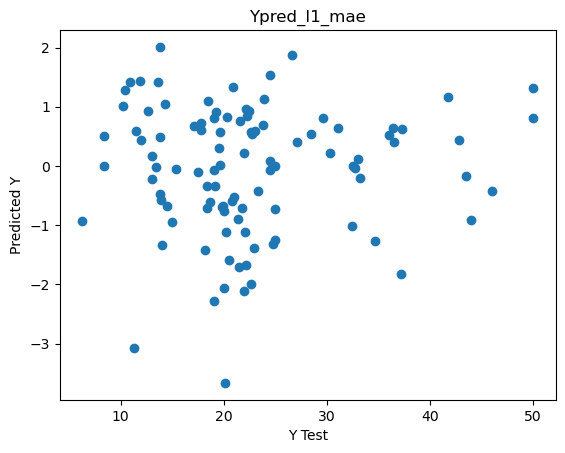

In [19]:
plot_predicted(Ypred_l1_mae, "Ypred_l1_mae")

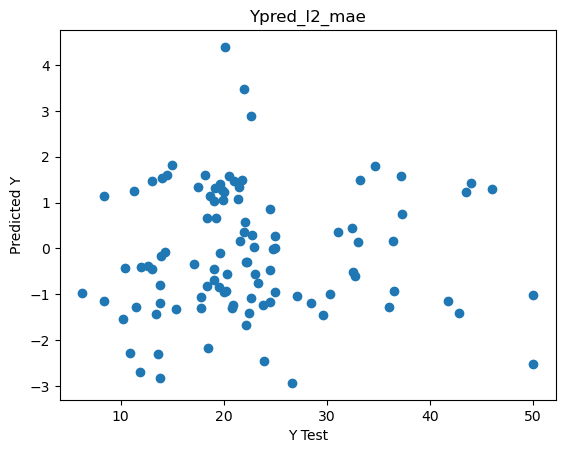

In [20]:
plot_predicted(Ypred_l2_mae, "Ypred_l2_mae")

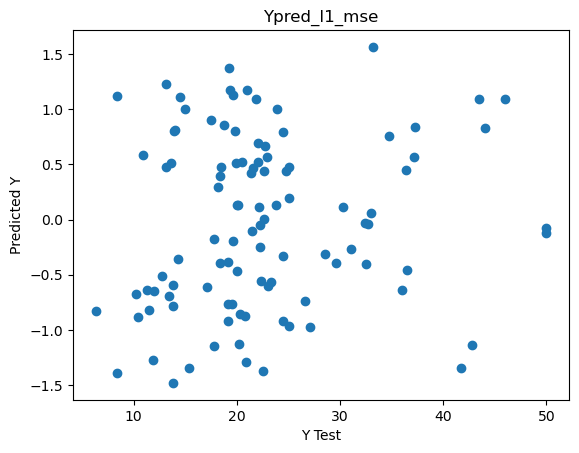

In [21]:
plot_predicted(Ypred_l1_mse, "Ypred_l1_mse")

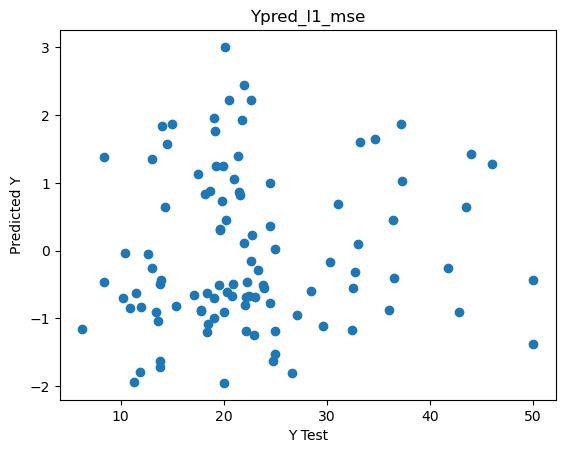

In [22]:
plot_predicted(Ypred_l2_mse, "Ypred_l1_mse")

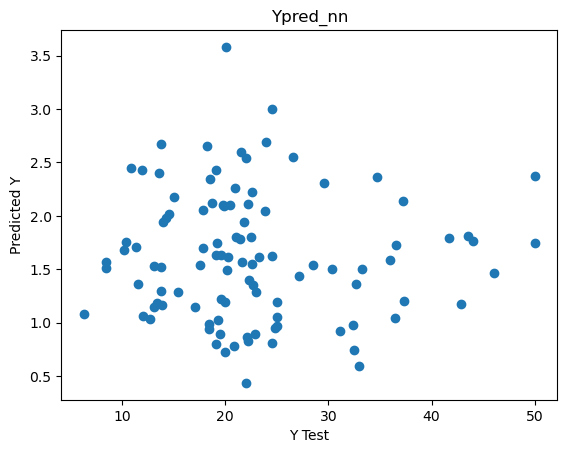

In [23]:
plot_predicted(Ypred_nn, "Ypred_nn")

In [24]:
#fig, axs = plt.subplots(2, 2, figsize=(10, 4))
#ax = axs.flatten()
#ax[0].scatter(Y_test, Ypred_l1_mae)
#ax[1].scatter(Y_test, Ypred_l2_mae)
#ax[2].scatter(Y_test, Ypred_l1_mse)
#ax[3].scatter(Y_test, Ypred_l2_mse)
#plt.xlabel('Y Test')
#plt.ylabel('Predicted Y')


In [25]:
print(f"R2 score for l1_mae: {r2_score(Y_test, Ypred_l1_mae)}")
print(f"R2 score for l2_mae: {r2_score(Y_test, Ypred_l2_mae)}")
print(f"R2 score for l1_mse: {r2_score(Y_test, Ypred_l1_mse)}")
print(f"R2 score for l2_mse: {r2_score(Y_test, Ypred_l2_mse)}")
print(f"R2 score for nn: {r2_score(Y_test, Ypred_nn)}")

R2 score for l1_mae: -6.078663649828233
R2 score for l2_mae: -6.1064451031224625
R2 score for l1_mse: -6.036009265415566
R2 score for l2_mse: -6.047509868830005
R2 score for nn: -5.210763313610116


Compare the $R^2$ scores of the models. You should be able to recognize large differences between the neural networks and linear regression models. Why do neural networks perform so much better on this task?

Non-Regularization method is used

Plot the error (also called 'residual') distribution for each model by plotting histograms of the differences between predicted and ground truth values.

Ideally, the residuals are normally distributed and centered at 0. 

In [26]:
def plot_residual(pred_value, mdl_name):
    residuals = Y_test - pred_value
    plt.hist(residuals, 20, alpha=0.5, label='residuals')
    plt.hist(Y_test, 20, alpha=0.5, label='ground_truth')
    plt.legend(loc='upper right')
    plt.title(mdl_name)
    plt.show()

In [27]:
# plot the error (residual) distribution for each model

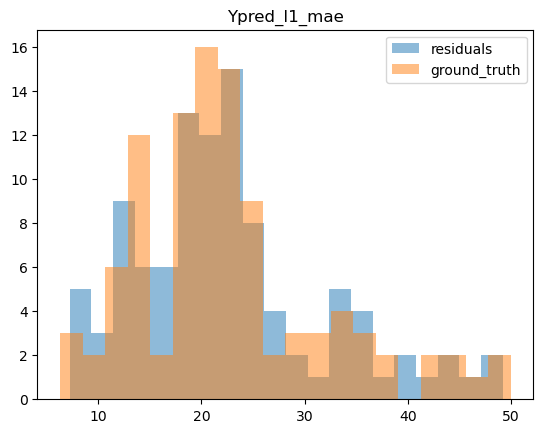

In [28]:
plot_residual(Ypred_l1_mae, "Ypred_l1_mae")

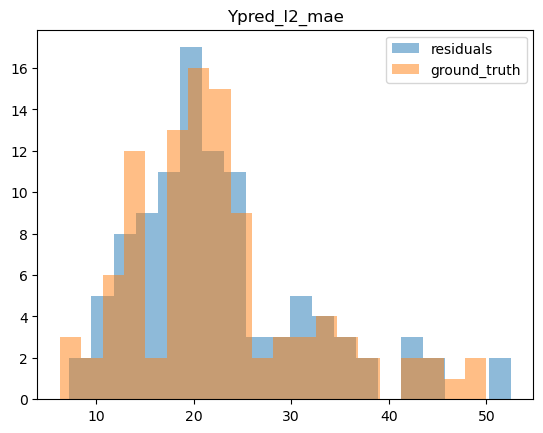

In [29]:
plot_residual(Ypred_l2_mae, "Ypred_l2_mae")

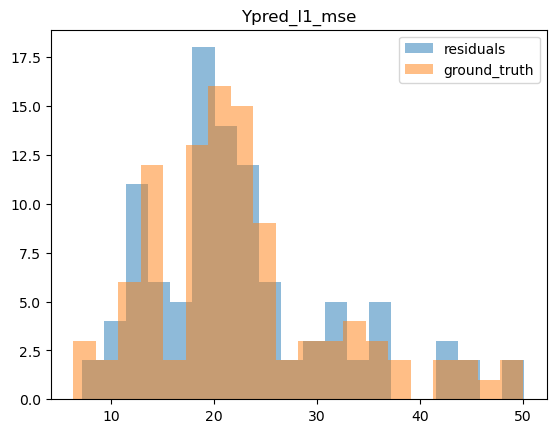

In [30]:
plot_residual(Ypred_l1_mse, "Ypred_l1_mse")

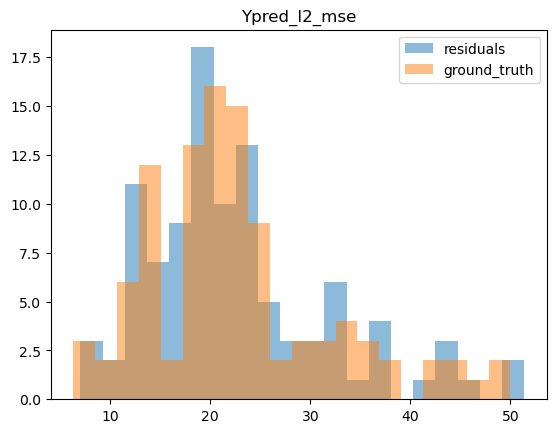

In [31]:
plot_residual(Ypred_l2_mse, "Ypred_l2_mse")

In [32]:
# print abs correlation with target
correlations = data.corrwith(target["MEDV"]).abs().sort_values(ascending=False)
print(correlations)

LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
dtype: float64


Train a linear regression model and a non-linear regression model on the variable that has the highest correlation with the target only.
Do a scatterplot of the data points and plot the regression model into the scatterplot.

In [33]:
most_corr_col = ["LSTAT", "RM", "PTRATIO"]
X_train_corr_col = X_train[most_corr_col]
X_test_corr_col = X_test[most_corr_col]
X_train_corr_col.head()

,LSTAT,RM,PTRATIO
60,0.069658,-0.774493,0.575395
413,1.041062,-1.609343,0.806576
285,-0.619998,0.239864,-1.459000
504,-0.865302,0.725672,1.176466
0,-1.075562,0.413672,-1.459000


In [34]:
trainset_corr_col = tf.data.Dataset.from_tensor_slices((X_train_corr_col, Y_train)).batch(256)
valset_corr_col = tf.data.Dataset.from_tensor_slices((X_test_corr_col, Y_test)).batch(1000)

In [35]:
def make_linear_mdl_l2_mse(input_shape=3):
    inx = Input(input_shape)
    x = layers.Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.L2(0.01))(inx)
    return Model(inx, x)

mdl_l2_mse_corr_col = make_linear_mdl_l2_mse()
mdl_l2_mse_corr_col.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error",
        )

hist_l2_mse_corr_col = mdl_l2_mse_corr_col.fit(trainset_corr_col,
                                      validation_data=valset_corr_col,
                                      epochs=10,
                  )

Epoch 1/10
2/2 [==============================] - 0s 90ms/step - loss: 593.3223 - val_loss: 600.6193
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 565.1913

2022-11-20 21:59:24.268293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:24.406075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 21ms/step - loss: 593.2228 - val_loss: 600.5190
Epoch 3/10
2/2 [==============================] - 0s 20ms/step - loss: 593.1246 - val_loss: 600.4190
Epoch 4/10
2/2 [==============================] - 0s 19ms/step - loss: 593.0267 - val_loss: 600.3192
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 592.9290 - val_loss: 600.2195
Epoch 6/10
2/2 [==============================] - 0s 19ms/step - loss: 592.8313 - val_loss: 600.1199
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 592.7336 - val_loss: 600.0204
Epoch 8/10
2/2 [==============================] - 0s 18ms/step - loss: 592.6362 - val_loss: 599.9209
Epoch 9/10
2/2 [==============================] - 0s 18ms/step - loss: 592.5388 - val_loss: 599.8215
Epoch 10/10
2/2 [==============================] - 0s 17ms/step - loss: 592.4413 - val_loss: 599.7222


In [36]:
def non_linear(input_shape=3):
    inx = Input(input_shape)
    x = layers.Dense(units=64, activation="relu")(inx)
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dense(units=1, activation=None)(x)
    return Model(inx, x)

nn_corr_col = non_linear()
nn_corr_col.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mean_squared_error",
          )

hist_nn_corr_col = nn_corr_col.fit(trainset_corr_col,
                 validation_data=valset_corr_col,
                 epochs=10,
                )

Epoch 1/10
1/2 [==============>...............] - ETA: 0s - loss: 559.6732

2022-11-20 21:59:25.156876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-20 21:59:25.333438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 108ms/step - loss: 590.2653 - val_loss: 593.9710
Epoch 2/10
2/2 [==============================] - 0s 18ms/step - loss: 586.6660 - val_loss: 590.4597
Epoch 3/10
2/2 [==============================] - 0s 18ms/step - loss: 583.1166 - val_loss: 587.0228
Epoch 4/10
2/2 [==============================] - 0s 17ms/step - loss: 579.6292 - val_loss: 583.6076
Epoch 5/10
2/2 [==============================] - 0s 15ms/step - loss: 576.1821 - val_loss: 580.2053
Epoch 6/10
2/2 [==============================] - 0s 17ms/step - loss: 572.7499 - val_loss: 576.7686
Epoch 7/10
2/2 [==============================] - 0s 18ms/step - loss: 569.2835 - val_loss: 573.3126
Epoch 8/10
2/2 [==============================] - 0s 17ms/step - loss: 565.7676 - val_loss: 569.8056
Epoch 9/10
2/2 [==============================] - 0s 15ms/step - loss: 562.2180 - val_loss: 566.2667
Epoch 10/10
2/2 [==============================] - 0s 16ms/step - loss: 558.6323 - val_loss: 562.6574

4/4 [==============================] - 0s 4ms/step


2022-11-20 21:59:25.680171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


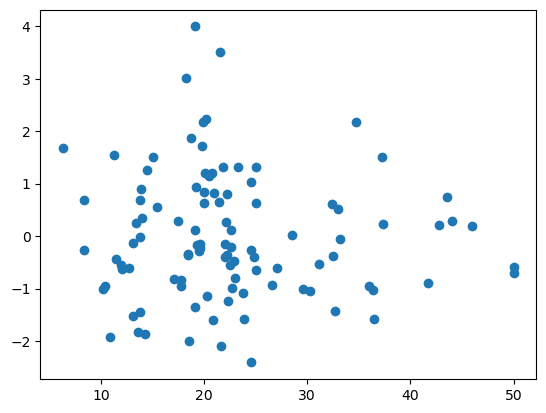

In [37]:
plt.scatter(Y_test, mdl_l2_mse_corr_col.predict(X_test_corr_col))

4/4 [==============================] - 0s 6ms/step


2022-11-20 21:59:26.529335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


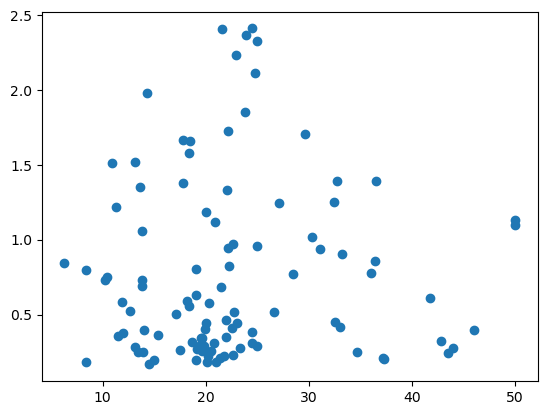

In [38]:
plt.scatter(Y_test, nn_corr_col.predict(X_test_corr_col))